# Introduction to machine learning

*Maxime Sangnier*

Fall, 2021

## Practical session 1: discriminant analysis, logistic regression and boosting

# Table of contents
1. [Discriminant analysis](#part1)
    - [Linear discriminant analysis](#part1sec1)
    - [Quadratic discriminant analysis](#part1sec2)
    - [Fisher discriminant analysis](#part1sec3)
1. [Logistic regression](#part2)
1. [Adaboost](#part3)


In [1]:
from mllab import *


Packages:
	nympy as np
	matplotlib.pyplot as plt
	seaborn as sns

Functions:
	plotXY
	plot_frontiere
	map_regions
	covariance
	plot_cov
	sample_gmm
	scatter
	plot_level_set
	gaussian_sample



# Discriminant analysis <a id="part1"></a>
## Linear discriminant analysis <a id="part1sec1"></a>
>The `covariance` function makes it possible to build a $2 \times 2$ covariance matrix based on spreads $\sigma_1$ and $\sigma_2$, and the angle $\theta$.

In [2]:
covariance?

Signature: covariance(sigma1=1.0, sigma2=1.0, theta=0.0)
Docstring: Covariance matrix with eigenvalues sigma1 and sigma2, rotated by the angle theta.
File:      ~/bitbucket/class/2017/5MS102_Apprentissage_non-supervisé/nb/m2/mllab.py
Type:      function


>Based on the Cholesky decomposition of a $2 \times 2$ covariance matrix $\Sigma$, write a function that generates a multivariate Gaussian $n$-sample of mean $\mu \in \mathbb R^2$ and covariance $\Sigma$.
The corresponding numpy array should be of size $(n, 2)$.

>Compute the mean and the empirical covariance of the sample using Numpy routines.

In [4]:
# Answer
def gaussian_sample(mu=[0, 0], sigma1=1., sigma2=1., theta=0., n=50):
    L = np.linalg.cholesky(covariance(sigma1, sigma2, theta)).T  # cov = L.T.dot(L)
    x = L.dot(np.random.randn(2, n)).T + np.array(mu)
    return x

X = gaussian_sample(sigma1=1, sigma2=10, n=500)

print("Mean:", X.mean(axis=0))
print("Covariance:", np.cov(X.T))

Mean: [-0.02520844 -0.05786368]
Covariance: [[ 1.00492595 -0.15206832]
 [-0.15206832 10.58878877]]


>Generate two multivariate Gaussian samples of size $n_1 = n_2 = 50$ with different means and equal covariance matrices.
Plot both samples with different markers by using the function `plotXY`.

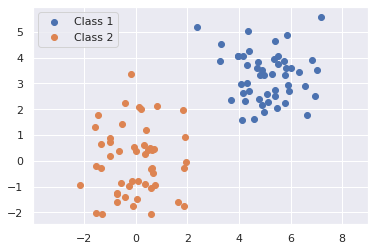

In [4]:
# Answer
X1 = gaussian_sample(mu=[0, 0])
X2 = gaussian_sample(mu=[5, 3])

plotXY(X1, X2)
plt.legend(loc="best");

>Based on the following code, implement a linear discriminant classifier, taking as parameters an $n \times 2$ Numpy array as data and a size-$n$ array of labels.

In [12]:
# Answer
from sklearn.base import BaseEstimator
from sklearn.discriminant_analysis import LinearClassifierMixin

class LDA(BaseEstimator, LinearClassifierMixin):
    """
        LDA classifier for two classes.
    """
    def __init__(self, prior=None):
        """
            prior: wether to use prior in the intercept. Default is false.
        """
        self.prior = prior
        
    def fit(self, X, y):
        # Estimate covariance matrix and means
        # Todo
        cov = np.cov(X.T)  # Covariance matrix
        invcov = np.linalg.inv(cov)  # Inverse covariance matrix
        mu1 = X[y==y.max(), :].mean(axis=0)
        mu2 = X[y==y.min(), :].mean(axis=0)
        # End todo
        if not self.prior:
            pi1, pi2 = 0.5, 0.5
        else:
            pi1, pi2 = np.mean(y == y.max()), np.mean(y == y.min())
        # Compute direction and intercept
        # Todo
        self.coef_ = invcov.dot(mu1-mu2)
        self.intercept_ = 0.5*(mu2.dot(invcov.dot(mu2)) - mu1.dot(invcov.dot(mu1))) + \
            np.log(pi1/pi2)
        # End todo
        return self

    def decision_function(self, X):
        # Compute decisions
        # Todo
        decisions = X.dot(self.coef_) + self.intercept_
        # End todo
        return decisions

    def predict(self, X):
        # Compute predictions
        # Todo
        predictions = (self.decision_function(X) > 0)*2 - 1
        # End todo
        return predictions

>Create the Numpy arrays `X` and `y` based on the samples generated previously and fit a linear discriminant classifier.
Plot the data along with the classifier frontiere (use the function `plot_frontiere`).

LDA parameters:
[-0.5126141  -0.85861911] 2.4758044657564384


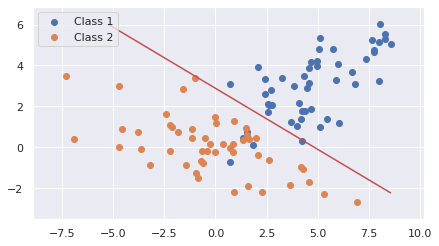

In [13]:
# Answer
X = np.r_[X1, X2]
Y = np.r_[np.ones(X1.shape[0]), -np.ones(X2.shape[0])]

lda = LDA()
lda.fit(X, Y)
print("LDA parameters:")
print(lda.coef_ / np.linalg.norm(lda.coef_), lda.intercept_ / np.linalg.norm(lda.coef_))

plot_frontiere(lda, X, Y)

>Compare the result of [scikit-learn LDA](http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis) (decision function and frontiere).

LDA parameters:
[[-0.5126141  -0.85861911]] [2.47580447]


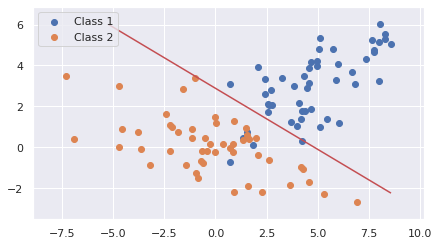

In [14]:
# Answer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda2 = LinearDiscriminantAnalysis()
lda2.fit(X, Y)
print("LDA parameters:")
print(lda2.coef_ / np.linalg.norm(lda2.coef_), lda2.intercept_ / np.linalg.norm(lda2.coef_))

plot_frontiere(lda2, X, Y)

## Quadratic discriminant analysis <a id="part1sec2"></a>
>Analyze the behavior of LDA and [QDA](http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis) when it is faced to anisotropic Gaussian samples (in particular, check if the frontiere is the bisector of the line segment for which the extremities are both class centers), and then to Gaussian samples with different covariance matrices (you can use `plot_frontiere` with a list of classifiers).

<Figure size 720x1440 with 0 Axes>

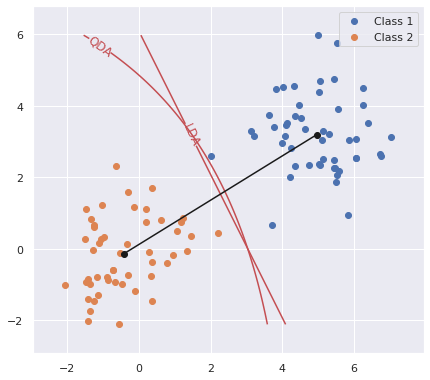

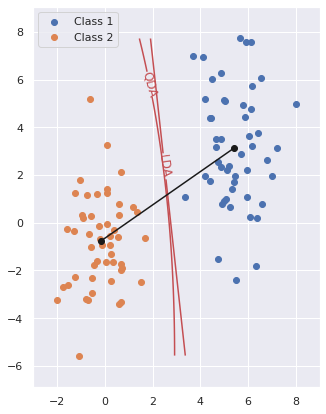

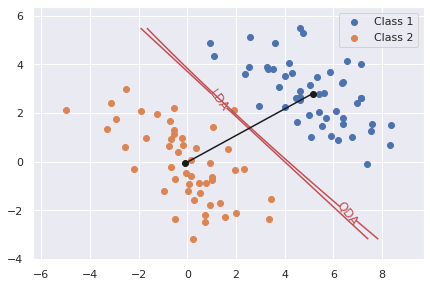

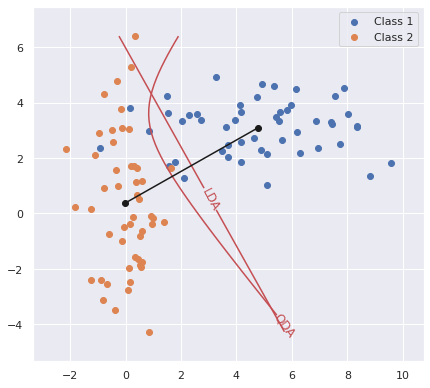

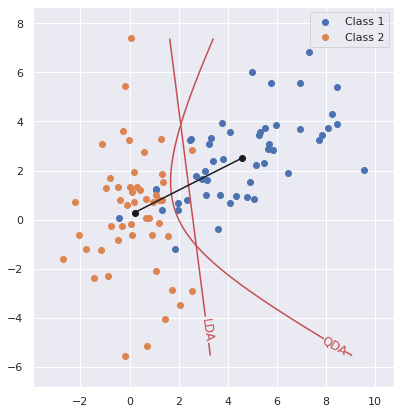

In [15]:
# Answer
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()

# Gassian parameters
mu1 = mu = [0, 0]
mu2 = [5, 3]

plt.figure(figsize=(10, 20))
for (p1, p2) in [((1, 1, 0), ) * 2,
                  ((1, 5, 0), ) * 2,
                  ((1, 5, np.pi/6), ) * 2,
                  ((1, 5, 0), (5, 1, 0)),
                  ((1, 5, 0), (5, 1, np.pi/3))]:
    # Dataset
    # Todo
    X1 = gaussian_sample(mu1, *p1)
    X2 = gaussian_sample(mu2, *p2)
    X = np.r_[X1, X2]
    Y = np.r_[np.ones(X1.shape[0]), -np.ones(X2.shape[0])]
    # End todo
    
    # Discriminant analysis
    # Todo
    lda.fit(X, Y)
    qda.fit(X, Y)
    # End todo
    
    # Class means
    # Todo
    mu1_emp = X[Y==Y.max()].mean(axis=0)
    mu2_emp = X[Y==Y.min()].mean(axis=0)
    # End todo
    
    # Plot frontieres and class means
    # Todo
    plot_frontiere([lda, qda], X, Y, label=["LDA", "QDA"])
    plt.plot([mu1_emp[0], mu2_emp[0]], [mu1_emp[1], mu2_emp[1]], 'ko-')  # Plot the line between class centers
    # End todo

## Fisher discriminant analysis <a id="part1sec3"></a>
>Implement the Fisher discriminant analysis based on the following code.
In practice, what is the difference between LDA and FisherDA?

In [16]:
class FisherDA(BaseEstimator, LinearClassifierMixin):
    """
        Fisher discriminant analysis for two classes.
    """
    def fit(self, X, y):
        pass

    def decision_function(self, X):
        pass

    def predict(self, X):
        pass

In [17]:
# Answer
class FisherDA(BaseEstimator, LinearClassifierMixin):
    """
        Fisher discriminant analysis for two classes.
    """
    def fit(self, X, y):
        # Estimate prior, covariance matrix and means
        # To do
        pi1, pi2 = np.mean(y == y.max()), np.mean(y == y.min())  # Priors
        cov1 = np.cov(X[y==y.max(), :].T)  # Covariance matrix class 1
        cov2 = np.cov(X[y==y.min(), :].T)  # Covariance matrix class 2
        cov = pi1*cov1 + pi2*cov2
        invcov = np.linalg.inv(cov)  # Inverse covariance matrix
        mu1 = X[y==y.max(), :].mean(axis=0)
        mu2 = X[y==y.min(), :].mean(axis=0)
        # End todo
        
        # Compute direction and intercept
        # Todo
        self.coef_ = invcov.dot(mu1-mu2)
        self.intercept_ = 0
        
        ypred = self.decision_function(X)
        ind = np.argsort(ypred)
        err = np.cumsum(y[ind]) + np.sum(y==y.min())
        #plt.figure()
        #plt.plot(ypred[ind], err)  # Error
        iintercept = np.argmin(err)
        if iintercept < y.size-1:
            self.intercept_ = -0.5*(ypred[ind[iintercept]] + ypred[ind[iintercept+1]])
        else:
            self.intercept_ = -ypred[ind[iintercept]]
        # End todo
        return self

    def decision_function(self, X):
        # Compute decisions
        # Todo
        decisions = X.dot(self.coef_) + self.intercept_
        # End todo
        return decisions

    def predict(self, X):
        # Compute predictions
        # Todo
        predictions = (self.decision_function(X) > 0)*2 - 1
        # End todo
        return predictions

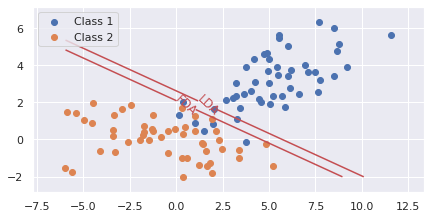

In [18]:
# Answer
X1 = gaussian_sample(mu=[0, 0], sigma1=8, theta=-np.pi/6)
X2 = gaussian_sample(mu=[5, 3], sigma1=8, theta=np.pi/3)

X = np.r_[X1, X2]
Y = np.r_[np.ones(X1.shape[0]), -np.ones(X2.shape[0])]

lda2.fit(X, Y)

fda = FisherDA()
fda.fit(X, Y)

plot_frontiere([lda2, fda], X, Y, label=["LDA", "FDA"])

# Logistic regression <a id="part2"></a>
>We consider that $X|Y=1 \sim \mathcal N(0, I)$ and $X|Y=-1 \sim 0.5 \mathcal N\left(\begin{pmatrix} 5 \\ 3 \end{pmatrix}, I\right) + 0.5 \mathcal N\left(\begin{pmatrix} 8 \\ 9 \end{pmatrix}, I\right)$ (non-Gaussian class).
Compare LDA and [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

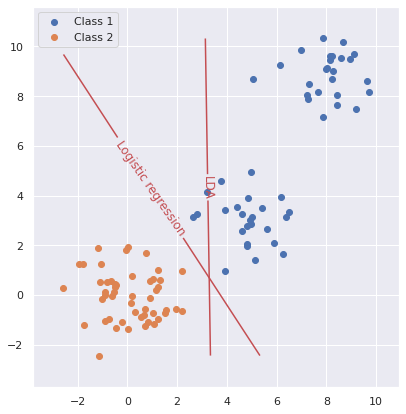

In [34]:
# Answer
from sklearn.linear_model import LogisticRegression

X1 = gaussian_sample(mu=[0, 0])
X2 = gaussian_sample(mu=[5, 3], n=25)
X3 = gaussian_sample(mu=[8, 9], n=25)

X = np.r_[X1, X2, X3]
Y = np.r_[np.ones(X1.shape[0]), -np.ones(X2.shape[0]), -np.ones(X3.shape[0])]

# Linear discriminant analysis
lda2.fit(X, Y)

# Logistic regression with big penalty parameter => unregularized
lr = LogisticRegression(C=1e8)
lr.fit(X, Y)

plot_frontiere([lda2, lr], X, Y, label=["LDA", "Logistic regression"])

>What about with this dataset (class $-1$ is Gaussian but with an outlier)?

In [13]:
# Dataset
X1 = gaussian_sample(mu=[0, 0])
X2 = gaussian_sample(mu=[5, 3], n=49)
X3 = gaussian_sample(mu=[20, 20], n=1).reshape(1, -1)

X = np.r_[X1, X2, X3]
Y = np.r_[np.ones(X1.shape[0]), -np.ones(X2.shape[0]), -np.ones(X3.shape[0])]

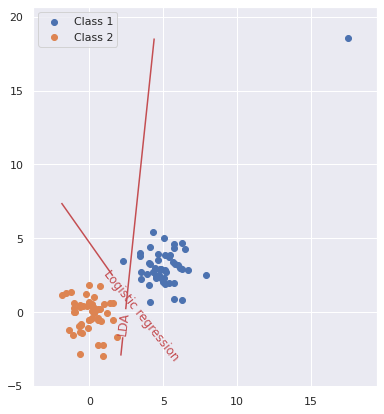

In [14]:
# Answer
# Linear discriminant analysis
lda2.fit(X, Y)

# Logistic regression with big penalty parameter => unregularized
lr = LogisticRegression(C=1e8)
lr.fit(X, Y)

plot_frontiere([lda2, lr], X, Y, label=["LDA", "Logistic regression"])

# Adaboost <a id="part3"></a>
>We consider the dataset defined below.

In [15]:
# Dataset
X1 = gaussian_sample(mu=[0, 0], sigma1=10, theta=np.pi/6)
X2 = gaussian_sample(mu=[5, 3], sigma1=3, sigma2=10, theta=np.pi/6, n=50)
X3 = gaussian_sample(mu=[-5, -2], sigma1=3, sigma2=10, theta=np.pi/10, n=50)

X = np.r_[X1, X2, X3]
Y = np.r_[np.ones(X1.shape[0]), -np.ones(X2.shape[0]), -np.ones(X3.shape[0])]

>Fit an [Adaboost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) classifier with $100$ weak learners and the algorithm SAMME.
Map the classifier regions on a figure.

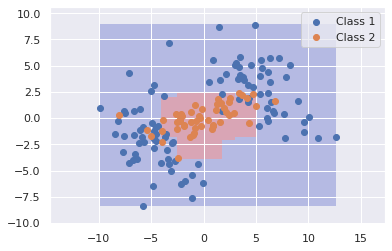

In [16]:
# Answer
from sklearn.ensemble import AdaBoostClassifier

# Adaboost classifier
n_estimators = 100
adb = AdaBoostClassifier(n_estimators = n_estimators, algorithm="SAMME")
adb.fit(X, Y)

map_regions(adb, X, Y)

>Plot on a new figure the estimator errors (attribute `estimator_errors_`).
What do you observe?

Text(0, 0.5, 'Weighted error')

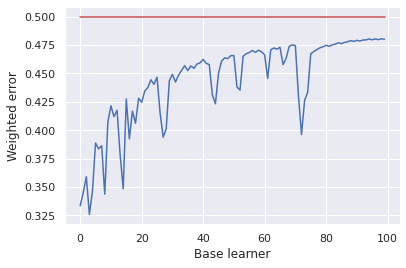

In [17]:
# Answer
plt.figure()
plt.plot(adb.estimator_errors_)
plt.plot([0, adb.n_estimators-1], [0.5]*2, 'r')
plt.xlabel("Base learner")
plt.ylabel("Weighted error")

>Load the [dataset digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits).
How many observations, covariates and classes has it?
[Split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) the dataset into two equally sized subsets (one for training, the other for testin, i.e. estimating the true error).

In [18]:
# Answer
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

X, Y = load_digits(return_X_y=True)
print("X shape:", X.shape)
print("Labels:", Y.min(), Y.max())

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.5)

X shape: (1797, 64)
Labels: 0 9


>Plot the train and test errors of both algorithms SAMME and SAMME.R with respect to the number of iterations (from 1 to 200) for the dataset digits.
For this purpose, use [`DecisionTreeClassifier(max_depth=5)`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) as base learner.

Text(0.5, 0, 'Adaboost iteration')

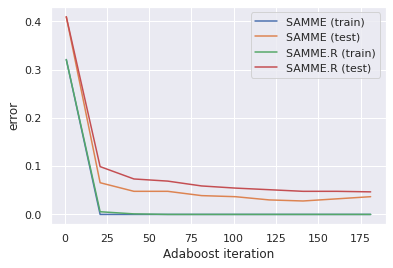

In [19]:
# Answer
from sklearn.tree import DecisionTreeClassifier

iterations = np.arange(1, 201, step=20, dtype=int)
err = []
errR = []
errTest = []
errRTest = []
for it in iterations:
    for l, lT, alg in [(err, errTest, 'SAMME'), (errR, errRTest, 'SAMME.R')]:
        adb = AdaBoostClassifier(n_estimators=it, algorithm=alg,
                                 base_estimator=DecisionTreeClassifier(max_depth=5),
                                 random_state=1)
        adb.fit(Xtrain, Ytrain)
        l.append(1-adb.score(Xtrain, Ytrain))
        lT.append(1-adb.score(Xtest, Ytest))

for l, lT, alg in [(err, errTest, 'SAMME'), (errR, errRTest, 'SAMME.R')]:
    plt.plot(iterations, l, label=alg+' (train)')
    plt.plot(iterations, lT, label=alg+' (test)')
plt.legend(loc="best");
plt.ylabel('error')
plt.xlabel("Adaboost iteration")